Размер: 512x512: 100%|██████████| 4/4 [00:18<00:00,  4.66s/it]


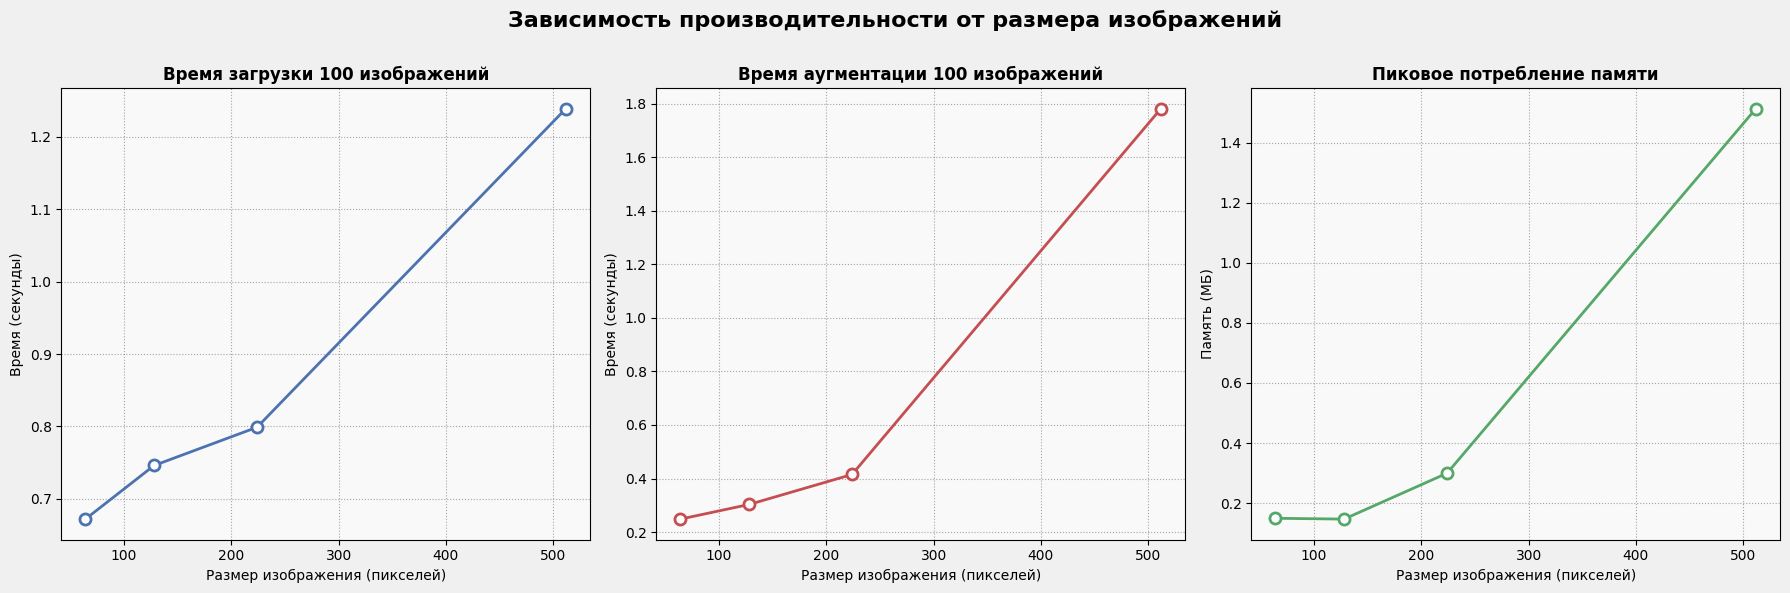

Размер     | Загрузка (с) | Аугментация (с) | Память (МБ) 
-------------------------------------------------------
64         | 0.6719       | 0.2485         | 0.15        
128        | 0.7460       | 0.3031         | 0.15        
224        | 0.7988       | 0.4151         | 0.30        
512        | 1.2393       | 1.7818         | 1.51        


In [8]:
import time
import tracemalloc
from torchvision import transforms
from torch.utils.data import Dataset
from tqdm import tqdm
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Конфигурация эксперимента
SIZES = [64, 128, 224, 512]
NUM_IMAGES = 100
REPEATS = 3  # Количество повторений для усреднения результатов
AUGMENTATIONS = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
    transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0)),
])

class ImageSizeExperimentDataset(Dataset):
    """Датасет для эксперимента с разными размерами"""
    
    def __init__(self, image_paths, target_size):
        self.image_paths = image_paths
        self.target_size = target_size
        self.resize = transforms.Resize(target_size)
        self.to_tensor = transforms.ToTensor()
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = Image.open(img_path).convert('RGB')
        img = self.resize(img)
        return self.to_tensor(img)

def collect_image_paths(data_path, num_images):
    """Собирает пути к изображениям"""
    image_paths = []
    
    for root, _, files in os.walk(data_path):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
                image_paths.append(os.path.join(root, file))
                if len(image_paths) >= num_images:
                    return image_paths
    
    return image_paths

def run_experiment(data_path):
    """Запускает эксперимент для разных размеров изображений"""
    # Собираем пути к изображениям
    image_paths = collect_image_paths(data_path, NUM_IMAGES)
    
    # Результаты
    results = {
        size: {
            'load_times': [],
            'aug_times': [],
            'memory_usages': []
        }
        for size in SIZES
    }
    
    # Прогресс-бар для размеров
    size_pbar = tqdm(SIZES, desc="Размеры изображений")
    
    for size in size_pbar:
        size_pbar.set_description(f"Размер: {size}x{size}")
        
        # Создаем датасет для текущего размера
        dataset = ImageSizeExperimentDataset(image_paths, (size, size))
        
        # Повторяем эксперимент несколько раз для стабильности
        for repeat in range(REPEATS):
            # Начинаем отслеживание памяти
            tracemalloc.start()
            
            # Загрузка данных
            start_time = time.time()
            images = []
            for i in range(len(dataset)):
                images.append(dataset[i])
            load_time = time.time() - start_time
            
            # Измерение памяти после загрузки
            _, load_peak = tracemalloc.get_traced_memory()
            tracemalloc.stop()
            
            # Применение аугментаций
            tracemalloc.start()
            start_time = time.time()
            for img in images:
                AUGMENTATIONS(img)
            aug_time = time.time() - start_time
            
            # Измерение памяти после аугментаций
            _, aug_peak = tracemalloc.get_traced_memory()
            tracemalloc.stop()
            
            # Сохраняем результаты
            results[size]['load_times'].append(load_time)
            results[size]['aug_times'].append(aug_time)
            results[size]['memory_usages'].append(max(load_peak, aug_peak) / (1024 ** 2))  # в MB
    
    # Усредняем результаты по повторениям
    for size in SIZES:
        results[size]['avg_load_time'] = np.mean(results[size]['load_times'])
        results[size]['avg_aug_time'] = np.mean(results[size]['aug_times'])
        results[size]['avg_memory'] = np.mean(results[size]['memory_usages'])
    
    return results

def plot_results(results):
    """Визуализирует результаты эксперимента с новыми цветами"""
    sizes = list(results.keys())
    load_times = [results[size]['avg_load_time'] for size in sizes]
    aug_times = [results[size]['avg_aug_time'] for size in sizes]
    memory_usages = [results[size]['avg_memory'] for size in sizes]
    
    # Создаем фигуру с тремя графиками
    plt.figure(figsize=(18, 6), facecolor='#f0f0f0')  # Светло-серый фон
    
    # Цвета для графиков
    colors = {
        'load': '#4c72b0',    # Синий
        'aug': '#c44e52',     # Красный
        'memory': '#55a868'   # Зеленый
    }
    
    # График 1: Время загрузки
    plt.subplot(1, 3, 1)
    plt.plot(sizes, load_times, 'o-', markersize=8, linewidth=2, 
             color=colors['load'], markerfacecolor='white', markeredgewidth=2)
    plt.title('Время загрузки 100 изображений', fontsize=12, fontweight='bold')
    plt.xlabel('Размер изображения (пикселей)', fontsize=10)
    plt.ylabel('Время (секунды)', fontsize=10)
    plt.gca().set_facecolor('#f9f9f9')
    plt.grid(True, linestyle=':', color='gray', alpha=0.7)
    
    # График 2: Время аугментации
    plt.subplot(1, 3, 2)
    plt.plot(sizes, aug_times, 'o-', markersize=8, linewidth=2, 
             color=colors['aug'], markerfacecolor='white', markeredgewidth=2)
    plt.title('Время аугментации 100 изображений', fontsize=12, fontweight='bold')
    plt.xlabel('Размер изображения (пикселей)', fontsize=10)
    plt.ylabel('Время (секунды)', fontsize=10)
    plt.gca().set_facecolor('#f9f9f9')
    plt.grid(True, linestyle=':', color='gray', alpha=0.7)
    
    # График 3: Потребление памяти
    plt.subplot(1, 3, 3)
    plt.plot(sizes, memory_usages, 'o-', markersize=8, linewidth=2, 
             color=colors['memory'], markerfacecolor='white', markeredgewidth=2)
    plt.title('Пиковое потребление памяти', fontsize=12, fontweight='bold')
    plt.xlabel('Размер изображения (пикселей)', fontsize=10)
    plt.ylabel('Память (МБ)', fontsize=10)
    plt.gca().set_facecolor('#f9f9f9')
    plt.grid(True, linestyle=':', color='gray', alpha=0.7)
    
    # Общий заголовок
    plt.suptitle('Зависимость производительности от размера изображений', 
                 fontsize=16, fontweight='bold')
    
    # Сохраняем результаты
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)  # Добавляем место для общего заголовка
    plt.savefig('size_experiment_results.png', dpi=150, facecolor='#f0f0f0')
    plt.show()
    
    # Выводим таблицу результатов
    print(f"{'Размер':<10} | {'Загрузка (с)':<12} | {'Аугментация (с)':<14} | {'Память (МБ)':<12}")
    print("-" * 55)
    for size in SIZES:
        print(f"{size:<10} | {results[size]['avg_load_time']:<12.4f} | {results[size]['avg_aug_time']:<14.4f} | {results[size]['avg_memory']:<12.2f}")


data_path = "data/train"
experiment_results = run_experiment(data_path)
plot_results(experiment_results)